## Introduction/Business Problem:

As a young realestate investor I am always looking for ways to efficiently examine potential properties to purchase.  the problem is using traditional property evaluation methods it takes years of experience and a great deal of local knowledge.  I am looking for ways to quickly and efficiently evaluate properties in mass and in potentially any area of the country, without having to be on the scene or using a local expert.  Also, the popular real estate listings website Redfin has added a specific new attribute to its listing - the 'fixer upper.'  These homes are advertised as being discounted because they will need some level of repair or updating.  As this is simply an attibute added by the listing agents I, as a potential investor, must be able to understand what a particular house would be worth under normal sale conditions, and then be able to decide if it is disounted enough, or if I have multiple potetial homes this method will help me quickly narrow the search down and identify those most likely to be priced under their potential value.

For this particular exercise I will be examining real estate currently listed on Staten Island, but if successful, these methods could be applied to any real estate market.

## Data to be incorporated

There are two primary data sources I will be using.  

The first is the active real estate data with is currently listed on Redfin.com for the NY borough of Staten Island. From redfin I will be able to query all currnet active listings and a number of their attributes, such as price, bedrooms, neighborhood, HOA, etc.  I will load these listings into my python script.  in addtion to the standard data in the redfin data feed, i will be adding an number other variables such as mortgage payments and total monthly budget for living in this property.

The real estate will be two data sets:
1.  a list of all standard listings in order to build a pricing model that predicts houses value under "normal" circumstances,
2.  a list of all "fixer upper" homes.  I will then apply the reuslts of the standard list to the fixer upper list and see what the sale price would theoretically be if the home were in normal condition.  from there I will see if it is truly discounted and if so, how much capital can I invest and still be able to sell the houses for a profit. 

The second data source will be the fourspare API for the general exploration of the Staten Island negiborhoods. Using the potential housing available I will explore the different neighborhoods and create new variables to append to the real estate listing records in order to build a linear regression model that will predict the value (sale price) of the home.  

This beginning section will be importing all of the libraries need during the analysis and begin the exporatory phase and innital model buidling for the price projecitons

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn import linear_model

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.linear_model import LinearRegression

%matplotlib inline



print('Libraries imported.')

Libraries imported.


In [13]:
Re_Comp_data=pd.read_csv('redfin_2020-08-19-17-18-45 staten Island control.csv', header=0)
RE_Fix_data=pd.read_csv('redfin_2020-08-19-17-13-31 stat fixer.csv', header=0)
zips=pd.read_excel('Stat Island Zips.xlsx', header=0)

In [14]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [15]:
print(Re_Comp_data.shape)
print(list(Re_Comp_data.columns))

(1786, 30)
['SALE TYPE', 'SOLD DATE', 'PROPERTY TYPE', 'ADDRESS', 'CITY', 'STATE OR PROVINCE', 'ZIP OR POSTAL CODE', 'PRICE', 'BEDS', 'BATHS', 'LOCATION', 'SQUARE FEET', 'LOT SIZE', 'YEAR BUILT', 'DAYS ON MARKET', '$/SQUARE FEET', 'HOA/MONTH', 'STATUS', 'NEXT OPEN HOUSE START TIME', 'NEXT OPEN HOUSE END TIME', 'URL (SEE http://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING)', 'SOURCE', 'MLS#', 'FAVORITE', 'INTERESTED', 'LATITUDE', 'LONGITUDE', 'Fixer_Upper', 'Pool', 'Garage']


In [16]:
print(RE_Fix_data.shape)
print(list(RE_Fix_data.columns))

(23, 30)
['SALE TYPE', 'SOLD DATE', 'PROPERTY TYPE', 'ADDRESS', 'CITY', 'STATE OR PROVINCE', 'ZIP OR POSTAL CODE', 'PRICE', 'BEDS', 'BATHS', 'LOCATION', 'SQUARE FEET', 'LOT SIZE', 'YEAR BUILT', 'DAYS ON MARKET', '$/SQUARE FEET', 'HOA/MONTH', 'STATUS', 'NEXT OPEN HOUSE START TIME', 'NEXT OPEN HOUSE END TIME', 'URL (SEE http://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING)', 'SOURCE', 'MLS#', 'FAVORITE', 'INTERESTED', 'LATITUDE', 'LONGITUDE', 'Fixer_Upper', 'Pool', 'Garage']


In [17]:
NY_Listings = [RE_Fix_data, Re_Comp_data]

In [18]:
NY_Listings = pd.concat(NY_Listings)

In [19]:
NY_Listings = NY_Listings.rename(columns={'ZIP OR POSTAL CODE': 'ZIP'})
NY_Listings = NY_Listings.rename(columns={'MLS#': 'MLS'})
NY_Listings = NY_Listings.rename(columns={'LOCATION': 'Neighborhood'})
NY_Listings = NY_Listings.rename(columns={'SQUARE FEET': 'SQUARE_FEET'})
NY_Listings = NY_Listings.rename(columns={'YEAR BUILT': 'YEAR_BUILT'})
NY_Listings = NY_Listings.rename(columns={'LOT SIZE': 'LOT_SIZE'})
NY_Listings = NY_Listings.rename(columns={'PROPERTY TYPE': 'PROPERTY_TYPE'})

In [20]:
NY_Listings.head()

SALE TYPE  SOLD DATE              PROPERTY_TYPE                 ADDRESS  \
0  MLS Listing        nan  Single Family Residential             83 Token St   
1  MLS Listing        nan                  Townhouse           72 Windom Ave   
2  MLS Listing        nan  Single Family Residential            5 Cascade St   
3  MLS Listing        nan  Single Family Residential  53 Village Ln Unit 14a   
4  MLS Listing        nan  Single Family Residential       1213 Richmond Ave   

            CITY STATE OR PROVINCE    ZIP   PRICE  BEDS   BATHS  Neighborhood  \
0  Staten Island                NY  10312  499000     3 2.00000      Annadale   
1  Staten Island                NY  10305  419000     4 2.00000      Arrochar   
2  Staten Island                NY  10306  499000     3 1.00000  Dongan Hills   
3  Staten Island                NY  10312  440000     2 1.00000   Eltingville   
4  Staten Island                NY  10314  599900     2 1.00000  Graniteville   

   SQUARE_FEET   LOT_SIZE  YEAR_BUILT  DAYS ON MARKET  $/SQUARE FEET  \
0         1150 2755.00000  1970.00000             198            434   
1         1306 2800.00000  1962.00000              71            321   
2         1248 3400.00000  1930.00000              50            400   
3         1346 2344.00000  1987.00000               8            327   
4          936 9620.00000  1945.00000              58            641   

   HOA/MONTH  STATUS NEXT OPEN HOUSE START TIME NEXT OPEN HOUSE END TIME  \
0        nan  Active                        NaN                      NaN   
1        nan  Active                        NaN                      NaN   
2        nan  Active                        NaN                      NaN   
3  305.00000  Active                        NaN                      NaN   
4        nan  Active                        NaN                      NaN   

  URL (SEE http://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING)  \
0  http://www.redfin.com/NY/Staten-Island/83-Toke...                                           
1  http://www.redfin.com/NY/Staten-Island/72-Wind...                                           
2  http://www.redfin.com/NY/Staten-Island/5-Casca...                                           
3  http://www.redfin.com/NY/Staten-Island/53-Vill...                                           
4  http://www.redfin.com/NY/Staten-Island/1213-Ri...                                           

     SOURCE      MLS FAVORITE INTERESTED  LATITUDE  LONGITUDE Fixer_Upper  \
0  SIBORMLS  1135344        N          Y  40.56207  -74.17651           Y   
1  SIBORMLS  1137402        N          Y  40.59559  -74.06438           Y   
2  SIBORMLS  1138027        N          Y  40.58169  -74.10336           Y   
3  SIBORMLS  1139475        N          Y  40.54290  -74.16923           Y   
4  SIBORMLS  1137661        N          Y  40.61819  -74.15508           Y   

  Pool Garage  
0    N      N  
1    N      N  
2    N      Y  
3    N      N  
4    N      N

In [21]:
print(NY_Listings.shape)
print(list(NY_Listings.columns))

(1809, 30)
['SALE TYPE', 'SOLD DATE', 'PROPERTY_TYPE', 'ADDRESS', 'CITY', 'STATE OR PROVINCE', 'ZIP', 'PRICE', 'BEDS', 'BATHS', 'Neighborhood', 'SQUARE_FEET', 'LOT_SIZE', 'YEAR_BUILT', 'DAYS ON MARKET', '$/SQUARE FEET', 'HOA/MONTH', 'STATUS', 'NEXT OPEN HOUSE START TIME', 'NEXT OPEN HOUSE END TIME', 'URL (SEE http://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING)', 'SOURCE', 'MLS', 'FAVORITE', 'INTERESTED', 'LATITUDE', 'LONGITUDE', 'Fixer_Upper', 'Pool', 'Garage']


In [22]:
NY_Listings = NY_Listings[['PROPERTY_TYPE','MLS', 'ADDRESS','BEDS','BATHS','SQUARE_FEET','LOT_SIZE', 'YEAR_BUILT','PRICE','Neighborhood','LATITUDE','LONGITUDE','Fixer_Upper','Pool', 'Garage']]

In [23]:
NY_List1 = NY_Listings.dropna()

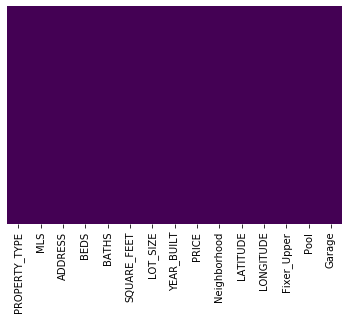

In [24]:
sns.heatmap(NY_List1.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [25]:
type_count = NY_List1.pivot_table(index =['PROPERTY_TYPE'],
                    aggfunc={'PROPERTY_TYPE':'count'})

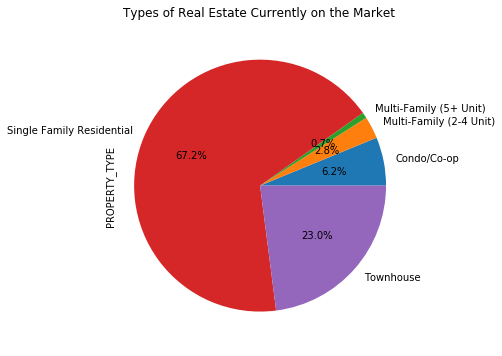

In [26]:
# autopct create %, start angle represent starting point
type_count['PROPERTY_TYPE'].plot(kind='pie',
                            figsize=(5, 6),
                            autopct='%1.1f%%', # add in percentages
                             
                            )

plt.title('Types of Real Estate Currently on the Market')
plt.axis('equal') # Sets the pie chart to look like a circle.

plt.show()

In [27]:
NY_List = NY_List1 [NY_List1['PROPERTY_TYPE'] != 'Condo/Co-op']

In [28]:
NY_List = NY_List [NY_List['PROPERTY_TYPE'] != 'Multi-Family (5+ Unit)']
NY_List = NY_List [NY_List['PROPERTY_TYPE'] != 'Multi-Family (2-4 Unit)']

In [29]:
NY_List= NY_List [NY_List['PRICE'] < 1000000]

In [30]:
NY_List_fu = NY_List [NY_List['Fixer_Upper'] == 'Y'] #these are our 'fixer uppers'

In [31]:
NY_List_cont = NY_List [NY_List['Fixer_Upper'] == 'N'] #normal home listings

In [32]:
NY_List_cont.describe()

BEDS      BATHS  SQUARE_FEET     LOT_SIZE  YEAR_BUILT  \
count 1401.00000 1401.00000   1401.00000   1401.00000  1401.00000   
mean     3.25339    2.54390   1707.54318   4180.93219  1971.92077   
std      0.94379    0.91419    628.06865  14751.96006    32.15785   
min      1.00000    0.50000    504.00000      1.00000  1865.00000   
25%      3.00000    2.00000   1260.00000   2200.00000  1950.00000   
50%      3.00000    2.00000   1552.00000   3065.00000  1980.00000   
75%      4.00000    3.00000   2093.00000   4200.00000  1996.00000   
max      9.00000    6.00000   8875.00000 392040.00000  2020.00000   

             PRICE   LATITUDE  LONGITUDE  
count   1401.00000 1401.00000 1401.00000  
mean  641858.97859   40.58159  -74.14340  
std   169903.53124    0.03717    0.04637  
min   182000.00000   40.49882  -74.25195  
25%   524000.00000   40.55160  -74.17247  
50%   629000.00000   40.58367  -74.14450  
75%   750000.00000   40.61286  -74.10311  
max   999999.00000   40.64794  -74.05978

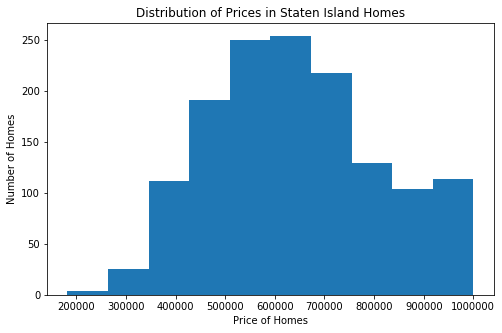

In [33]:
NY_List_cont['PRICE'].plot(kind='hist', figsize=(8, 5))

plt.title('Distribution of Prices in Staten Island Homes') # add a title to the histogram
plt.ylabel('Number of Homes') # add y-label
plt.xlabel('Price of Homes') # add x-label

plt.show()

In [34]:
address = 'New York, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [35]:
housing_map = folium.Map(location=[latitude, longitude], zoom_start=10) # generate map 

# add the houses restaurants as blue circle markers
for LATITUDE, LONGITUDE, label in zip(NY_List_cont.LATITUDE, NY_List_cont.LONGITUDE, NY_List_cont.PROPERTY_TYPE):
    folium.features.CircleMarker(
        [LATITUDE, LONGITUDE],
        radius=2.5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=1
    ).add_to(housing_map)
    
housing_map

In [36]:
NY_List_cont.corr()['PRICE'].sort_values()

LATITUDE      -0.24813
LONGITUDE     -0.12588
LOT_SIZE       0.02953
YEAR_BUILT     0.10821
BEDS           0.51565
BATHS          0.52282
SQUARE_FEET    0.68259
PRICE          1.00000
Name: PRICE, dtype: float64

In [37]:
Z=NY_List_cont[['BEDS','BATHS','SQUARE_FEET']] 
P=NY_List_cont[['PRICE']] 

In [38]:
lm = LinearRegression()
lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [39]:
lm.fit(Z,P)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [40]:
lm.intercept_

array([209806.22179413])

In [41]:
lm.coef_

array([[33594.71024177, 38172.17146878,   132.14890801]])

In [42]:
lm.score(Z,P)

0.5370579468171552

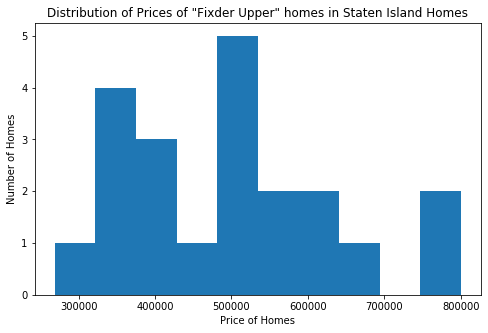

In [43]:
NY_List_fu['PRICE'].plot(kind='hist', figsize=(8, 5))

plt.title('Distribution of Prices of "Fixder Upper" homes in Staten Island Homes') # add a title to the histogram
plt.ylabel('Number of Homes') # add y-label
plt.xlabel('Price of Homes') # add x-label

plt.show()

In [44]:
NY_List_fu_testing = NY_List_fu

In [45]:
for pro_price, row in NY_List_fu_testing.iterrows():
    NY_List_fu_testing.loc[pro_price, "projected_price"] = 209806.22179413+ (row ['BEDS']*33594.71024177) + (row ['BATHS']*38172.17146878)+(row ['SQUARE_FEET']*132.14890801)

/Users/dfishe/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/dfishe/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [46]:
for price_diff, row in NY_List_fu_testing.iterrows():
    NY_List_fu_testing.loc[price_diff, "price_diff"] = row ['PRICE'] - row ['projected_price']

In [47]:
NY_List_fu_testing.head(25)

PROPERTY_TYPE      MLS                 ADDRESS  BEDS   BATHS  \
0   Single Family Residential  1135344             83 Token St     3 2.00000   
1                   Townhouse  1137402           72 Windom Ave     4 2.00000   
2   Single Family Residential  1138027            5 Cascade St     3 1.00000   
3   Single Family Residential  1139475  53 Village Ln Unit 14a     2 1.00000   
4   Single Family Residential  1137661       1213 Richmond Ave     2 1.00000   
5   Single Family Residential  1134387       44 Summerfield Pl     3 3.00000   
6   Single Family Residential  1139444           185 South Ave     4 1.00000   
7   Single Family Residential  1135483          206 Brabant St     3 2.00000   
8   Single Family Residential  1138199          304 Sanilac St     3 2.00000   
9                   Townhouse  1139388           25 Layton Ave     2 1.00000   
10  Single Family Residential  1131254          36 Fillmore St     4 1.00000   
11                  Townhouse  1137590          94 Dorothea Pl     3 2.00000   
12  Single Family Residential  1133086         254 Jacques Ave     2 2.00000   
13  Single Family Residential   432100            166 Roma Ave     3 1.00000   
14  Single Family Residential  1139549            13 Hooker Pl     3 1.00000   
16  Single Family Residential  1139213          244 Hylan Blvd     4 2.00000   
18  Single Family Residential  1138374        133 Glenwood Ave     2 2.00000   
19  Single Family Residential  1139125          137 Yetman Ave     3 2.00000   
20  Single Family Residential  1139003         329 Oakland Ave     6 1.00000   
21                  Townhouse  1130429       361 Livermore Ave     5 3.00000   
22  Single Family Residential  1130281          925 Jewett Ave     3 3.00000   

    SQUARE_FEET   LOT_SIZE  YEAR_BUILT   PRICE      Neighborhood  LATITUDE  \
0          1150 2755.00000  1970.00000  499000          Annadale  40.56207   
1          1306 2800.00000  1962.00000  419000          Arrochar  40.59559   
2          1248 3400.00000  1930.00000  499000      Dongan Hills  40.58169   
3          1346 2344.00000  1987.00000  440000       Eltingville  40.54290   
4           936 9620.00000  1945.00000  599900      Graniteville  40.61819   
5          1260 1551.00000  1996.00000  349000      Graniteville  40.62533   
6          1536 3625.00000  1915.00000  375000  Mariner's Harbor  40.63534   
7          1518 2784.00000  1988.00000  329900  Mariner's Harbor  40.63200   
8          1200 2300.00000  1960.00000  488000     Midland Beach  40.57384   
9          2096 8176.00000  1910.00000  549000      New Brighton  40.64190   
10         1644 2600.00000  1920.00000  360000      New Brighton  40.64486   
11         1848 8147.00000  1950.00000  658800          New Dorp  40.57350   
12          736 2700.00000  1925.00000  420000          New Dorp  40.57036   
13         1000 2050.00000  1930.00000  269000          New Dorp  40.56175   
14          938 2500.00000  1915.00000  399000     Port Richmond  40.63057   
16         1150 2500.00000  1925.00000  519000          Rosebank  40.61177   
18         1132 6900.00000  1899.00000  639000         Sunnyside  40.61641   
19         1200 2960.00000  1901.00000  489000       Tottenville  40.51296   
20         2844 9945.00000  1915.00000  800000     West Brighton  40.63418   
21         1680 4000.00000  1925.00000  799900       Westerleigh  40.61493   
22         1200 4100.00000  1965.00000  579000       Westerleigh  40.61382   

    LONGITUDE Fixer_Upper Pool Garage  projected_price    price_diff  
0   -74.17651           Y    N      N     538905.93967  -39905.93967  
1   -74.06438           Y    N      N     593115.87956 -174115.87956  
2   -74.10336           Y    N      Y     513684.36118  -14684.36118  
3   -74.16923           Y    N      N     493040.24393  -53040.24393  
4   -74.15508           Y    N      N     438859.19164  161040.80836  
5   -74.16072           Y    N      N     591614.49102 -242614.49102  
6   -74.16594           Y    N      N    

In [48]:
price_delta = NY_List_fu_testing[['PRICE','projected_price','price_diff']] 

In [49]:
price_delta.describe()

PRICE  projected_price    price_diff
count     21.00000         21.00000      21.00000
mean  499071.42857     564717.33257  -65645.90400
std   143316.67085      88575.73164  119800.43788
min   269000.00000     438859.19164 -257636.73782
25%   399000.00000     502932.54908 -174115.87956
50%   489000.00000     572500.64991  -53040.24393
75%   579000.00000     592151.92494  -14684.36118
max   800000.00000     825378.14909  161040.80836

the next section will be exploring the Staten Island area and begin clustering the neighborhoods using the foursquare api

In [50]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [51]:
neighborhoods_data = newyork_data['features']

In [52]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [53]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


In [54]:
Staten_Island_data = neighborhoods[neighborhoods['Borough'] == 'Staten Island'].reset_index(drop=True)
Staten_Island_data.head()

Borough   Neighborhood  Latitude  Longitude
0  Staten Island     St. George  40.64498  -74.07935
1  Staten Island   New Brighton  40.64061  -74.08702
2  Staten Island      Stapleton  40.62693  -74.07790
3  Staten Island       Rosebank  40.61530  -74.06981
4  Staten Island  West Brighton  40.63188  -74.10718

In [55]:
address = 'Staten Island, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Staten Island are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Staten Island are 40.5834557, -74.1496048.


In [56]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(Staten_Island_data['Borough'].unique()),
        Staten_Island_data.shape[0]
    )
)


The dataframe has 1 boroughs and 63 neighborhoods.


Your credentails:
CLIENT_ID: KARNGMJWOURD3LZYPRHGS3IEKZUZQF351EMRPWCYLI1BLKRJ
CLIENT_SECRET:JXEXLAJQH3JQ2PFEWFPF1GJ21OILUCMHAEL0Y5MTPQTWCJT1


In [58]:
Staten_Island_data.loc[0, 'Neighborhood']

'St. George'

In [59]:
neighborhood_latitude = Staten_Island_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = Staten_Island_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = Staten_Island_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of St. George are 40.6449815710044, -74.07935312512797.


In [60]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 1600 # define radius

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=KARNGMJWOURD3LZYPRHGS3IEKZUZQF351EMRPWCYLI1BLKRJ&client_secret=JXEXLAJQH3JQ2PFEWFPF1GJ21OILUCMHAEL0Y5MTPQTWCJT1&v=20180604&ll=40.6449815710044,-74.07935312512797&radius=1600&limit=100'

In [61]:
results = requests.get(url).json()

In [62]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [63]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

name           categories      lat       lng
0                                 Beso     Tapas Restaurant 40.64331 -74.07651
1  Staten Island September 11 Memorial  Monument / Landmark 40.64677 -74.07651
2                         A&S Pizzeria          Pizza Place 40.64394 -74.07763
3                          Shake Shack         Burger Joint 40.64366 -74.07589
4                        Enoteca Maria   Italian Restaurant 40.64194 -74.07732

In [64]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

80 venues were returned by Foursquare.


In [65]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [66]:

Staten_Island_venues = getNearbyVenues(names=Staten_Island_data['Neighborhood'],
                                   latitudes=Staten_Island_data['Latitude'],
                                   longitudes=Staten_Island_data['Longitude']
                                  )



St. George
New Brighton
Stapleton
Rosebank
West Brighton
Grymes Hill
Todt Hill
South Beach
Port Richmond
Mariner's Harbor
Port Ivory
Castleton Corners
New Springville
Travis
New Dorp
Oakwood
Great Kills
Eltingville
Annadale
Woodrow
Tottenville
Tompkinsville
Silver Lake
Sunnyside
Park Hill
Westerleigh
Graniteville
Arlington
Arrochar
Grasmere
Old Town
Dongan Hills
Midland Beach
Grant City
New Dorp Beach
Bay Terrace
Huguenot
Pleasant Plains
Butler Manor
Charleston
Rossville
Arden Heights
Greenridge
Heartland Village
Chelsea
Bloomfield
Bulls Head
Richmond Town
Shore Acres
Clifton
Concord
Emerson Hill
Randall Manor
Howland Hook
Elm Park
Manor Heights
Willowbrook
Sandy Ground
Egbertville
Prince's Bay
Lighthouse Hill
Richmond Valley
Fox Hills


In [67]:
print(Staten_Island_venues.shape)
Staten_Island_venues.head()

(837, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0   St. George               40.64498               -74.07935   
1   St. George               40.64498               -74.07935   
2   St. George               40.64498               -74.07935   
3   St. George               40.64498               -74.07935   
4   St. George               40.64498               -74.07935   

                                 Venue  Venue Latitude  Venue Longitude  \
0                                 Beso        40.64331        -74.07651   
1                         A&S Pizzeria        40.64394        -74.07763   
2  Staten Island September 11 Memorial        40.64677        -74.07651   
3        Richmond County Bank Ballpark        40.64506        -74.07686   
4                          Shake Shack        40.64366        -74.07589   

        Venue Category  
0     Tapas Restaurant  
1          Pizza Place  
2  Monument / Landmark  
3     Baseball Stadium  
4         Burger Joint

In [68]:
Staten_Island_venues.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  Venue  \
Neighborhood                                                              
Annadale                              12                      12     12   
Arden Heights                          4                       4      4   
Arlington                              6                       6      6   
Arrochar                              24                      24     24   
Bay Terrace                           10                      10     10   
Bloomfield                             4                       4      4   
Bulls Head                            45                      45     45   
Butler Manor                           6                       6      6   
Castleton Corners                     16                      16     16   
Charleston                            29                      29     29   
Chelsea                                6                       6      6   
Clifton                               22                      22     22   
Concord                                7                       7      7   
Dongan Hills                          24                      24     24   
Egbertville                            4                       4      4   
Elm Park                              10                      10     10   
Eltingville                           38                      38     38   
Emerson Hill                           2                       2      2   
Fox Hills                              5                       5      5   
Graniteville                           5                       5      5   
Grant City                            20                      20     20   
Grasmere                              26                      26     26   
Great Kills                           22                      22     22   
Greenridge                             7                       7      7   
Grymes Hill                            4                       4      4   
Heartland Village                     11                      11     11   
Huguenot                               9                       9      9   
Lighthouse Hill                        5                       5      5   
Manor Heights                         12                      12     12   
Mariner's Harbor                       6                       6      6   
Midland Beach                         12                      12     12   
New Brighton                          12                      12     12   
New Dorp                              26                      26     26   
New Dorp Beach                        13                      13     13   
New Springville                       22                      22     22   
Oakwood                                4                       4      4   
Old Town                              18                      18     18   
Park Hill                              6                       6      6   
Pleasant Plains                       20                      20     20   
Port Richmond                          7                       7      7   
Prince's Bay                          11                      11     11   
Randall Manor                          5                       5      5   
Richmond Town                          4                       4      4   
Richmond Valley                       13                      13     13   
Rosebank                              24                      24     24   
Rossville                             15                      15     15   
Sandy Ground                           4                       4      4   
Shore Acres                           24                      24     24   
Silver Lake                            3                       3      3   
South Beach                            6                       6      6   
St. George                            36                      36     36   
Stapleton                             33    

In [69]:
Stat_Island_V = Staten_Island_venues.groupby('Neighborhood').count()

In [70]:
Stat_Island_V.head()

Neighborhood Latitude  Neighborhood Longitude  Venue  \
Neighborhood                                                          
Annadale                          12                      12     12   
Arden Heights                      4                       4      4   
Arlington                          6                       6      6   
Arrochar                          24                      24     24   
Bay Terrace                       10                      10     10   

               Venue Latitude  Venue Longitude  Venue Category  
Neighborhood                                                    
Annadale                   12               12              12  
Arden Heights               4                4               4  
Arlington                   6                6               6  
Arrochar                   24               24              24  
Bay Terrace                10               10              10

In [71]:
Stat_Island_VC = Stat_Island_V[['Venue']]

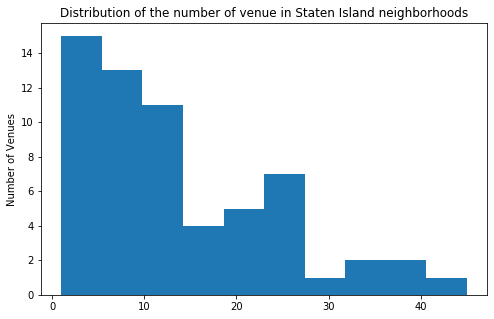

In [72]:
Stat_Island_VC['Venue'].plot(kind='hist', figsize=(8, 5))

plt.title('Distribution of the number of venue in Staten Island neighborhoods') # add a title to the histogram
plt.ylabel('Number of Venues') # add y-label


plt.show()

In [73]:
print('There are {} uniques categories.'.format(len(Staten_Island_venues['Venue Category'].unique())))

There are 180 uniques categories.


In [74]:
# one hot encoding
Staten_Island_onehot = pd.get_dummies(Staten_Island_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Staten_Island_onehot['Neighborhood'] = Staten_Island_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Staten_Island_onehot.columns[-1]] + list(Staten_Island_onehot.columns[:-1])
manhattan_onehot = Staten_Island_onehot[fixed_columns]

Staten_Island_onehot.head()

Accessories Store  American Restaurant  Arcade  Art Gallery  Art Museum  \
0                  0                    0       0            0           0   
1                  0                    0       0            0           0   
2                  0                    0       0            0           0   
3                  0                    0       0            0           0   
4                  0                    0       0            0           0   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  BBQ Joint  \
0                    0                 0                   0          0   
1                    0                 0                   0          0   
2                    0                 0                   0          0   
3                    0                 0                   0          0   
4                    0                 0                   0          0   

   Bagel Shop  Bakery  Bank  Bar  Baseball Field  Baseball Stadium  \
0           0       0     0    0               0                 0   
1           0       0     0    0               0                 0   
2           0       0     0    0               0                 0   
3           0       0     0    0               0                 1   
4           0       0     0    0               0                 0   

   Basketball Court  Beach  Beer Bar  Big Box Store  Board Shop  \
0                 0      0         0              0           0   
1                 0      0         0              0           0   
2                 0      0         0              0           0   
3                 0      0         0              0           0   
4                 0      0         0              0           0   

   Boat or Ferry  Bookstore  Bowling Alley  Breakfast Spot  Brewery  \
0              0          0              0               0        0   
1              0          0              0               0        0   
2              0          0              0               0        0   
3              0          0              0               0        0   
4              0          0              0               0        0   

   Bridal Shop  Bubble Tea Shop  Burger Joint  Bus Station  Bus Stop  Butcher  \
0            0                0             0            0         0        0   
1            0                0             0            0         0        0   
2            0                0             0            0         0        0   
3            0                0             0            0         0        0   
4            0                0             1            0         0        0   

   Café  Cajun / Creole Restaurant  Campground  Caribbean Restaurant  \
0     0                          0           0                     0   
1     0                          0           0                     0   
2     0                          0           0                     0   
3     0                          0           0                     0   
4     0                          0           0                     0   

   Check Cashing Service  Chinese Restaurant  Clothing Store  Coffee Shop  \
0                      0                   0               0            0   
1                      0                   0               0            0   
2                      0                   0               0            0   
3                      0                   0               0            0   
4                      0                   0               0            0   

   Comedy Club  Construction & Landscaping  Convenience Store  Cosmetics Shop  \
0            0                           0                  0               0   
1            0                           0                  0               0   
2            0                           0                  0               0   
3            0                           0                  0               0   
4            0                           0  

In [75]:
Staten_Island_grouped = Staten_Island_onehot.groupby('Neighborhood').mean().reset_index()
Staten_Island_grouped

Neighborhood  Accessories Store  American Restaurant  Arcade  \
0            Annadale            0.00000              0.08333 0.00000   
1       Arden Heights            0.00000              0.00000 0.00000   
2           Arlington            0.00000              0.16667 0.00000   
3            Arrochar            0.00000              0.00000 0.00000   
4         Bay Terrace            0.00000              0.00000 0.00000   
5          Bloomfield            0.00000              0.00000 0.00000   
6          Bulls Head            0.00000              0.02222 0.00000   
7        Butler Manor            0.00000              0.00000 0.00000   
8   Castleton Corners            0.00000              0.00000 0.00000   
9          Charleston            0.00000              0.03448 0.00000   
10            Chelsea            0.00000              0.00000 0.00000   
11            Clifton            0.00000              0.04545 0.00000   
12            Concord            0.00000              0.00000 0.00000   
13       Dongan Hills            0.00000              0.00000 0.00000   
14        Egbertville            0.00000              0.00000 0.00000   
15           Elm Park            0.00000              0.10000 0.00000   
16        Eltingville            0.00000              0.00000 0.00000   
17       Emerson Hill            0.00000              0.00000 0.00000   
18          Fox Hills            0.00000              0.20000 0.00000   
19       Graniteville            0.00000              0.00000 0.00000   
20         Grant City            0.00000              0.00000 0.00000   
21           Grasmere            0.00000              0.00000 0.00000   
22        Great Kills            0.00000              0.00000 0.00000   
23         Greenridge            0.00000              0.00000 0.00000   
24        Grymes Hill            0.00000              0.00000 0.00000   
25  Heartland Village            0.09091              0.00000 0.00000   
26           Huguenot            0.00000              0.00000 0.00000   
27    Lighthouse Hill            0.00000              0.00000 0.00000   
28      Manor Heights            0.00000              0.08333 0.00000   
29   Mariner's Harbor            0.00000              0.00000 0.00000   
30      Midland Beach            0.00000              0.00000 0.00000   
31       New Brighton            0.00000              0.00000 0.00000   
32           New Dorp            0.00000              0.00000 0.00000   
33     New Dorp Beach            0.00000              0.00000 0.00000   
34    New Springville            0.04545              0.00000 0.00000   
35            Oakwood            0.00000              0.00000 0.00000   
36           Old Town            0.00000              0.05556 0.00000   
37          Park Hill            0.00000              0.00000 0.00000   
38    Pleasant Plains            0.00000              0.00000 0.00000   
39      Port Richmond            0.00000              0.00000 0.00000   
40       Prince's Bay            0.00000              0.00000 0.00000   
41      Randall Manor            0.00000              0.00000 0.00000   
42      Richmond Town            0.00000              0.00000 0.00000   
43    Richmond Valley            0.00000              0.00000 0.00000   
44           Rosebank            0.00000              0.00000 0.00000   
45          Rossville            0.00000              0.06667 0.00000   
46       Sandy Ground            0.00000              0.00000 0.00000   
47        Shore Acres            0.00000              0.00000 0.00000   
48        Silver Lake            0.00000              0.33333 0.00000   
49        South Beach            0.00000              0.00000 0.00000   
50         St. George            0.00000              0.02778 0.00000   
51          Stapleton            0.00000              0.03030 0.00000   
52          Sunnyside            0.00000              0.16667 0.00000   
53          Todt Hill            0.00000              0.00000 0.000

In [76]:
Staten_Island_grouped.shape

(61, 181)

In [77]:
num_top_venues = 5

for hood in Staten_Island_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Staten_Island_grouped[Staten_Island_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Annadale----
                 venue    freq
0          Pizza Place 0.25000
1                Diner 0.08000
2  American Restaurant 0.08000
3           Restaurant 0.08000
4         Liquor Store 0.08000


----Arden Heights----
               venue    freq
0      Deli / Bodega 0.25000
1        Coffee Shop 0.25000
2           Pharmacy 0.25000
3        Pizza Place 0.25000
4  Accessories Store 0.00000


----Arlington----
                 venue    freq
0             Bus Stop 0.33000
1  American Restaurant 0.17000
2        Deli / Bodega 0.17000
3        Boat or Ferry 0.17000
4        Grocery Store 0.17000


----Arrochar----
                venue    freq
0            Bus Stop 0.12000
1       Deli / Bodega 0.08000
2  Italian Restaurant 0.08000
3         Pizza Place 0.08000
4          Bagel Shop 0.08000


----Bay Terrace----
                venue    freq
0         Supermarket 0.20000
1  Salon / Barbershop 0.10000
2    Sushi Restaurant 0.10000
3      Shipping Store 0.10000
4       Train Station 

In [78]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [79]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Staten_Island_grouped['Neighborhood']

for ind in np.arange(Staten_Island_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Staten_Island_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0       Annadale           Pizza Place         Train Station   
1  Arden Heights         Deli / Bodega           Coffee Shop   
2      Arlington              Bus Stop         Deli / Bodega   
3       Arrochar              Bus Stop    Italian Restaurant   
4    Bay Terrace           Supermarket    Italian Restaurant   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0                  Food                  Park              Pharmacy   
1              Pharmacy           Pizza Place        Discount Store   
2   American Restaurant         Boat or Ferry         Grocery Store   
3           Pizza Place            Bagel Shop         Deli / Bodega   
4      Sushi Restaurant          Home Service            Donut Shop   

  6th Most Common Venue   7th Most Common Venue     8th Most Common Venue  \
0          Liquor Store              Restaurant       American Restaurant   
1        Farmers Market       French Restaurant                Food Truck   
2   Filipino Restaurant  Furniture / Home Store         French Restaurant   
3           Supermarket            Liquor Store  Mediterranean Restaurant   
4    Salon / Barbershop          Shipping Store          Insurance Office   

       9th Most Common Venue 10th Most Common Venue  
0             Cosmetics Shop                  Diner  
1          Food & Drink Shop                   Food  
2                 Food Truck      Food & Drink Shop  
3  Middle Eastern Restaurant             Food Truck  
4              Train Station       Asian Restaurant

In [80]:
# set number of clusters
kclusters = 5

Staten_Island_grouped_clustering = Staten_Island_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Staten_Island_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 4, 2, 4, 4, 2, 4, 4, 4, 4], dtype=int32)

In [81]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster_Labels', kmeans.labels_)

Staten_Island_merged = Staten_Island_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Staten_Island_merged = Staten_Island_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Staten_Island_merged.head() # check the last columns!

Borough   Neighborhood  Latitude  Longitude  Cluster_Labels  \
0  Staten Island     St. George  40.64498  -74.07935         4.00000   
1  Staten Island   New Brighton  40.64061  -74.08702         2.00000   
2  Staten Island      Stapleton  40.62693  -74.07790         4.00000   
3  Staten Island       Rosebank  40.61530  -74.06981         4.00000   
4  Staten Island  West Brighton  40.63188  -74.10718         4.00000   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0        Clothing Store    Italian Restaurant                   Bar   
1              Bus Stop                  Park         Deli / Bodega   
2           Pizza Place        Discount Store                  Bank   
3    Italian Restaurant           Pizza Place         Grocery Store   
4           Coffee Shop        Breakfast Spot    Italian Restaurant   

  4th Most Common Venue      5th Most Common Venue 6th Most Common Venue  \
0   Sporting Goods Shop                   Pharmacy      Tapas Restaurant   
1      Greek Restaurant             Discount Store            Playground   
2                   Bar             Sandwich Place                  Park   
3        Breakfast Spot  Cajun / Creole Restaurant        Sandwich Place   
4              Pharmacy                        Bar                  Bank   

  7th Most Common Venue                     8th Most Common Venue  \
0        Farmers Market                              Burger Joint   
1           Bridal Shop                             Bowling Alley   
2        Cosmetics Shop  Residential Building (Apartment / Condo)   
3            Restaurant                            Ice Cream Shop   
4           Music Store                            Cosmetics Shop   

  9th Most Common Venue 10th Most Common Venue  
0           Snack Place         Scenic Lookout  
1          Home Service            Event Space  
2            Restaurant            Coffee Shop  
3        Discount Store               Pharmacy  
4        Sandwich Place      Food & Drink Shop

In [82]:
cluster_count = Staten_Island_merged['Cluster_Labels'].value_counts()

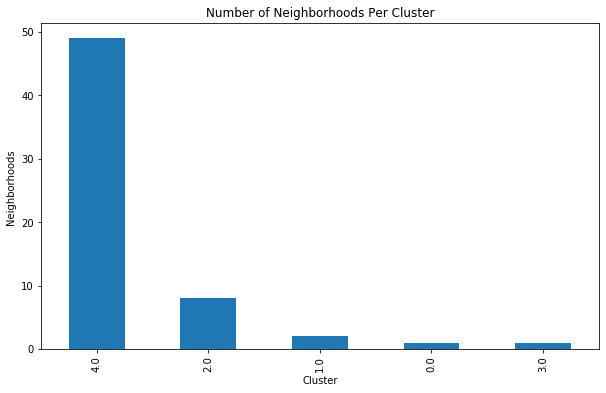

In [83]:
cluster_count.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Cluster') # add to x-label to the plot
plt.ylabel('Neighborhoods ') # add y-label to the plot
plt.title('Number of Neighborhoods Per Cluster') # add title to the plot

plt.show()

In [84]:
Staten_Island_merged = Staten_Island_merged.dropna()

In [85]:
Staten_Island_merged['Cluster_Labels'] = Staten_Island_merged['Cluster_Labels'].astype(int)

In [86]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Staten_Island_merged['Latitude'], Staten_Island_merged['Longitude'], Staten_Island_merged['Neighborhood'], Staten_Island_merged['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [87]:
Staten_Island_merged.loc[Staten_Island_merged['Cluster_Labels'] == 0, Staten_Island_merged.columns[[1] + list(range(5, Staten_Island_merged.shape[1]))]]

Neighborhood       1st Most Common Venue 2nd Most Common Venue  \
51  Emerson Hill  Construction & Landscaping                  Food   

   3rd Most Common Venue 4th Most Common Venue   5th Most Common Venue  \
51           Yoga Studio        Farmers Market  Furniture / Home Store   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
51     French Restaurant            Food Truck     Food & Drink Shop   

   9th Most Common Venue 10th Most Common Venue  
51           Flower Shop    Filipino Restaurant

In [88]:
Staten_Island_merged.loc[Staten_Island_merged['Cluster_Labels'] == 1, Staten_Island_merged.columns[[1] + list(range(5, Staten_Island_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
6       Todt Hill                  Park           Yoga Studio   
52  Randall Manor                  Park              Bus Stop   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
6            Gas Station     French Restaurant            Food Truck   
52          Home Service            Bagel Shop           Yoga Studio   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
6      Food & Drink Shop                  Food           Flower Shop   
52        Farmers Market     French Restaurant            Food Truck   

   9th Most Common Venue 10th Most Common Venue  
6    Filipino Restaurant   Fast Food Restaurant  
52     Food & Drink Shop                   Food

In [89]:
Staten_Island_merged.loc[Staten_Island_merged['Cluster_Labels'] == 2, Staten_Island_merged.columns[[1] + list(range(5, Staten_Island_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
1   New Brighton              Bus Stop                  Park   
5    Grymes Hill              Bus Stop         Deli / Bodega   
24     Park Hill              Bus Stop                 Hotel   
27     Arlington              Bus Stop         Deli / Bodega   
45    Bloomfield            Theme Park     Recreation Center   
56   Willowbrook              Bus Stop         Deli / Bodega   
57  Sandy Ground              Bus Stop          Intersection   
62     Fox Hills              Bus Stop   American Restaurant   

   3rd Most Common Venue 4th Most Common Venue   5th Most Common Venue  \
1          Deli / Bodega      Greek Restaurant          Discount Store   
5                Dog Run  Fast Food Restaurant  Furniture / Home Store   
24    Athletics & Sports           Coffee Shop    Gym / Fitness Center   
27   American Restaurant         Boat or Ferry           Grocery Store   
45          Burger Joint              Bus Stop             Yoga Studio   
56                   Spa    Chinese Restaurant              Bagel Shop   
57          Home Service        Farmers Market  Furniture / Home Store   
62        Sandwich Place         Grocery Store             Yoga Studio   

   6th Most Common Venue   7th Most Common Venue 8th Most Common Venue  \
1             Playground             Bridal Shop         Bowling Alley   
5      French Restaurant              Food Truck     Food & Drink Shop   
24           Yoga Studio    Fast Food Restaurant     French Restaurant   
27   Filipino Restaurant  Furniture / Home Store     French Restaurant   
45     French Restaurant              Food Truck     Food & Drink Shop   
56        Farmers Market       French Restaurant            Food Truck   
57     French Restaurant              Food Truck     Food & Drink Shop   
62        Farmers Market       French Restaurant            Food Truck   

   9th Most Common Venue 10th Most Common Venue  
1           Home Service            Event Space  
5                   Food            Flower Shop  
24            Food Truck      Food & Drink Shop  
27            Food Truck      Food & Drink Shop  
45                  Food            Flower Shop  
56     Food & Drink Shop                   Food  
57                  Food            Flower Shop  
62     Food & Drink Shop                   Food

In [90]:
Staten_Island_merged.loc[Staten_Island_merged['Cluster_Labels'] == 3, Staten_Island_merged.columns[[1] + list(range(5, Staten_Island_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
15      Oakwood                Lawyer        Nightlife Spot   

   3rd Most Common Venue 4th Most Common Venue   5th Most Common Venue  \
15              Bus Stop        Farmers Market  Furniture / Home Store   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
15     French Restaurant            Food Truck     Food & Drink Shop   

   9th Most Common Venue 10th Most Common Venue  
15                  Food            Flower Shop

In [91]:
Staten_Island_merged.loc[Staten_Island_merged['Cluster_Labels'] == 4, Staten_Island_merged.columns[[1] + list(range(5, Staten_Island_merged.shape[1]))]]

Neighborhood 1st Most Common Venue       2nd Most Common Venue  \
0          St. George        Clothing Store          Italian Restaurant   
2           Stapleton           Pizza Place              Discount Store   
3            Rosebank    Italian Restaurant                 Pizza Place   
4       West Brighton           Coffee Shop              Breakfast Spot   
7         South Beach                  Pier                       Beach   
8       Port Richmond           Pizza Place               Deli / Bodega   
9    Mariner's Harbor    Italian Restaurant               Deli / Bodega   
11  Castleton Corners           Pizza Place              Ice Cream Shop   
12    New Springville     Accessories Store                         Spa   
13             Travis                 Hotel                         Gym   
14           New Dorp    Italian Restaurant           Indian Restaurant   
16        Great Kills    Italian Restaurant                         Bar   
17        Eltingville           Pizza Place            Sushi Restaurant   
18           Annadale           Pizza Place               Train Station   
19            Woodrow                 Diner                        Bank   
20        Tottenville    Italian Restaurant      Thrift / Vintage Store   
21      Tompkinsville              Bus Stop                     Brewery   
22        Silver Lake   American Restaurant                 Golf Course   
23          Sunnyside               Theater         American Restaurant   
25        Westerleigh                Arcade                 Art Gallery   
26       Graniteville              Wine Bar               Boat or Ferry   
28           Arrochar              Bus Stop          Italian Restaurant   
29           Grasmere              Bus Stop               Grocery Store   
30           Old Town    Italian Restaurant                      Bakery   
31       Dongan Hills           Pizza Place                  Bagel Shop   
32      Midland Beach                 Beach                  Restaurant   
33         Grant City           Pizza Place        Fast Food Restaurant   
34     New Dorp Beach    Italian Restaurant               Deli / Bodega   
35        Bay Terrace           Supermarket          Italian Restaurant   
36           Huguenot                  Bank          Italian Restaurant   
37    Pleasant Plains            Donut Shop                 Yoga Studio   
38       Butler Manor                  Pool              Baseball Field   
39         Charleston        Cosmetics Shop               Big Box Store   
40          Rossville           Pizza Place                  Bagel Shop   
41      Arden Heights         Deli / Bodega                 Coffee Shop   
42         Greenridge                 Diner  Construction & Landscaping   
43  Heartland Village     Accessories Store                         Spa   
44            Chelsea                  Park          Spanish Restaurant   
46         Bulls Head           Pizza Place                    Bus Stop   
47      Richmond Town    Italian Restaurant                         Spa   
48        Shore Acres    Italian Restaurant                    Bus Stop   
49            Clifton         Train Station          Mexican Restaurant   
50            Concord         Deli / Bodega               Train Station   
54           Elm Park         Deli / Bodega          Italian Restaurant   
55      Manor Heights         Deli / Bodega                Liquor Store   
58        Egbertville    Italian Restaurant              Cosmetics Shop   
59       Prince's Bay           Pizza Place                Liquor Store   
60    Lighthouse Hill    Italian Restaurant                  Art Museum   
61    Richmond Valley  Fast Food Restaurant                        Bank   

      3rd Most Common Venue 4th Most Common Venue      5th Most Common Venue  \
0                       Bar   Sporting Goods Shop                   Pharmacy   
2                      Bank                   Bar             Sandwich Place   
3             Groc

In [92]:
Staten_Island_venues.head()Staten_Island_merged

SyntaxError: invalid syntax (<ipython-input-92-70d4fcc42ae3>, line 1)

In [93]:
SI_venue_cluster = pd.merge(Staten_Island_venues,  
                      Staten_Island_merged,  
                      on ='Neighborhood',  
                      how ='left') 
SI_venue_cluster.head() 

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0   St. George               40.64498               -74.07935   
1   St. George               40.64498               -74.07935   
2   St. George               40.64498               -74.07935   
3   St. George               40.64498               -74.07935   
4   St. George               40.64498               -74.07935   

                                 Venue  Venue Latitude  Venue Longitude  \
0                                 Beso        40.64331        -74.07651   
1                         A&S Pizzeria        40.64394        -74.07763   
2  Staten Island September 11 Memorial        40.64677        -74.07651   
3        Richmond County Bank Ballpark        40.64506        -74.07686   
4                          Shake Shack        40.64366        -74.07589   

        Venue Category        Borough  Latitude  Longitude  Cluster_Labels  \
0     Tapas Restaurant  Staten Island  40.64498  -74.07935               4   
1          Pizza Place  Staten Island  40.64498  -74.07935               4   
2  Monument / Landmark  Staten Island  40.64498  -74.07935               4   
3     Baseball Stadium  Staten Island  40.64498  -74.07935               4   
4         Burger Joint  Staten Island  40.64498  -74.07935               4   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0        Clothing Store    Italian Restaurant                   Bar   
1        Clothing Store    Italian Restaurant                   Bar   
2        Clothing Store    Italian Restaurant                   Bar   
3        Clothing Store    Italian Restaurant                   Bar   
4        Clothing Store    Italian Restaurant                   Bar   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0   Sporting Goods Shop              Pharmacy      Tapas Restaurant   
1   Sporting Goods Shop              Pharmacy      Tapas Restaurant   
2   Sporting Goods Shop              Pharmacy      Tapas Restaurant   
3   Sporting Goods Shop              Pharmacy      Tapas Restaurant   
4   Sporting Goods Shop              Pharmacy      Tapas Restaurant   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0        Farmers Market          Burger Joint           Snack Place   
1        Farmers Market          Burger Joint           Snack Place   
2        Farmers Market          Burger Joint           Snack Place   
3        Farmers Market          Burger Joint           Snack Place   
4        Farmers Market          Burger Joint           Snack Place   

  10th Most Common Venue  
0         Scenic Lookout  
1         Scenic Lookout  
2         Scenic Lookout  
3         Scenic Lookout  
4         Scenic Lookout

In [94]:
 SI_venue_cluster['Cluster_Labels'].value_counts()

4    778
2     47
1      6
3      4
0      2
Name: Cluster_Labels, dtype: int64

In [95]:
cluster_count

4.00000    49
2.00000     8
1.00000     2
0.00000     1
3.00000     1
Name: Cluster_Labels, dtype: int64

In [96]:
NY_List.head()

PROPERTY_TYPE      MLS                 ADDRESS  BEDS   BATHS  \
0  Single Family Residential  1135344             83 Token St     3 2.00000   
1                  Townhouse  1137402           72 Windom Ave     4 2.00000   
2  Single Family Residential  1138027            5 Cascade St     3 1.00000   
3  Single Family Residential  1139475  53 Village Ln Unit 14a     2 1.00000   
4  Single Family Residential  1137661       1213 Richmond Ave     2 1.00000   

   SQUARE_FEET   LOT_SIZE  YEAR_BUILT   PRICE  Neighborhood  LATITUDE  \
0         1150 2755.00000  1970.00000  499000      Annadale  40.56207   
1         1306 2800.00000  1962.00000  419000      Arrochar  40.59559   
2         1248 3400.00000  1930.00000  499000  Dongan Hills  40.58169   
3         1346 2344.00000  1987.00000  440000   Eltingville  40.54290   
4          936 9620.00000  1945.00000  599900  Graniteville  40.61819   

   LONGITUDE Fixer_Upper Pool Garage  
0  -74.17651           Y    N      N  
1  -74.06438           Y    N      N  
2  -74.10336           Y    N      Y  
3  -74.16923           Y    N      N  
4  -74.15508           Y    N      N

In [97]:
NY_List_working = pd.merge(NY_List,  
                      Staten_Island_merged,  
                      on ='Neighborhood',  
                      how ='left') 
NY_List_working.head() 

PROPERTY_TYPE      MLS                 ADDRESS  BEDS   BATHS  \
0  Single Family Residential  1135344             83 Token St     3 2.00000   
1                  Townhouse  1137402           72 Windom Ave     4 2.00000   
2  Single Family Residential  1138027            5 Cascade St     3 1.00000   
3  Single Family Residential  1139475  53 Village Ln Unit 14a     2 1.00000   
4  Single Family Residential  1137661       1213 Richmond Ave     2 1.00000   

   SQUARE_FEET   LOT_SIZE  YEAR_BUILT   PRICE  Neighborhood  LATITUDE  \
0         1150 2755.00000  1970.00000  499000      Annadale  40.56207   
1         1306 2800.00000  1962.00000  419000      Arrochar  40.59559   
2         1248 3400.00000  1930.00000  499000  Dongan Hills  40.58169   
3         1346 2344.00000  1987.00000  440000   Eltingville  40.54290   
4          936 9620.00000  1945.00000  599900  Graniteville  40.61819   

   LONGITUDE Fixer_Upper Pool Garage        Borough  Latitude  Longitude  \
0  -74.17651           Y    N      N  Staten Island  40.53811  -74.17855   
1  -74.06438           Y    N      N  Staten Island  40.59631  -74.06712   
2  -74.10336           Y    N      Y  Staten Island  40.58867  -74.09640   
3  -74.16923           Y    N      N  Staten Island  40.54223  -74.16433   
4  -74.15508           Y    N      N  Staten Island  40.62017  -74.15315   

   Cluster_Labels 1st Most Common Venue 2nd Most Common Venue  \
0         4.00000           Pizza Place         Train Station   
1         4.00000              Bus Stop    Italian Restaurant   
2         4.00000           Pizza Place            Bagel Shop   
3         4.00000           Pizza Place      Sushi Restaurant   
4         4.00000              Wine Bar         Boat or Ferry   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0                  Food                  Park              Pharmacy   
1           Pizza Place            Bagel Shop         Deli / Bodega   
2    Italian Restaurant         Tattoo Parlor                  Bank   
3    Italian Restaurant                  Bank          Liquor Store   
4            Food Truck           Bus Station         Grocery Store   

  6th Most Common Venue 7th Most Common Venue     8th Most Common Venue  \
0          Liquor Store            Restaurant       American Restaurant   
1           Supermarket          Liquor Store  Mediterranean Restaurant   
2            Smoke Shop  Fast Food Restaurant        Chinese Restaurant   
3          Gourmet Shop        Sandwich Place      Fast Food Restaurant   
4           Yoga Studio  Fast Food Restaurant         French Restaurant   

       9th Most Common Venue 10th Most Common Venue  
0             Cosmetics Shop                  Diner  
1  Middle Eastern Restaurant             Food Truck  
2           Sushi Restaurant         Sandwich Place  
3             Breakfast Spot               Bus Stop  
4          Food & Drink Shop                   Food

In [133]:
print(NY_List_working.shape)

(1422, 27)


In [98]:
NY_DF_FA = NY_List_working[['PROPERTY_TYPE', 'ADDRESS','BEDS','BATHS','SQUARE_FEET','PRICE','LATITUDE','LONGITUDE','Fixer_Upper','Neighborhood','Pool','Garage','Cluster_Labels']]

In [99]:
print(NY_DF_FA.shape)

(1422, 13)


In [100]:
# create map
map_houses_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Staten_Island_merged['Latitude'], Staten_Island_merged['Longitude'], Staten_Island_merged['Neighborhood'], Staten_Island_merged['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=15,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_houses_clusters)

    
for LATITUDE, LONGITUDE, label in zip(NY_List_cont.LATITUDE, NY_List_cont.LONGITUDE, NY_List_cont.PROPERTY_TYPE):
    folium.features.CircleMarker(
        [LATITUDE, LONGITUDE],
        radius=1,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=1
    ).add_to(map_houses_clusters)
       
map_houses_clusters

I am now begining on working on the update machine learning algarithim to predict prices.  I will secondarily apply the algarithym to the "fixer upper" listings

In [154]:
NY_DF_FA.head()

PROPERTY_TYPE                 ADDRESS  BEDS   BATHS  \
0  Single Family Residential             83 Token St     3 2.00000   
1                  Townhouse           72 Windom Ave     4 2.00000   
2  Single Family Residential            5 Cascade St     3 1.00000   
3  Single Family Residential  53 Village Ln Unit 14a     2 1.00000   
4  Single Family Residential       1213 Richmond Ave     2 1.00000   

   SQUARE_FEET   PRICE  LATITUDE  LONGITUDE Fixer_Upper  Neighborhood Pool  \
0         1150  499000  40.56207  -74.17651           Y      Annadale    N   
1         1306  419000  40.59559  -74.06438           Y      Arrochar    N   
2         1248  499000  40.58169  -74.10336           Y  Dongan Hills    N   
3         1346  440000  40.54290  -74.16923           Y   Eltingville    N   
4          936  599900  40.61819  -74.15508           Y  Graniteville    N   

  Garage  Cluster_Labels  
0      N         4.00000  
1      N         4.00000  
2      Y         4.00000  
3      N         4.00000  
4      N         4.00000

In [127]:
#data = NY_DF_FA [NY_DF_FA['Fixer_Upper'] == 'N'] #normal home listings for analysis and machine learning

In [175]:
data = NY_DF_FA

In [176]:
cat_vars=['Pool','Garage','Neighborhood','Cluster_Labels']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(data[var], prefix=var)
    data1=data.join(cat_list)
    data=data1
cat_vars=['Pool','Garage','Neighborhood','Cluster_Labels']
data_vars=data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]

In [177]:
data.head()

PROPERTY_TYPE                 ADDRESS  BEDS   BATHS  \
0  Single Family Residential             83 Token St     3 2.00000   
1                  Townhouse           72 Windom Ave     4 2.00000   
2  Single Family Residential            5 Cascade St     3 1.00000   
3  Single Family Residential  53 Village Ln Unit 14a     2 1.00000   
4  Single Family Residential       1213 Richmond Ave     2 1.00000   

   SQUARE_FEET   PRICE  LATITUDE  LONGITUDE Fixer_Upper  Neighborhood Pool  \
0         1150  499000  40.56207  -74.17651           Y      Annadale    N   
1         1306  419000  40.59559  -74.06438           Y      Arrochar    N   
2         1248  499000  40.58169  -74.10336           Y  Dongan Hills    N   
3         1346  440000  40.54290  -74.16923           Y   Eltingville    N   
4          936  599900  40.61819  -74.15508           Y  Graniteville    N   

  Garage  Cluster_Labels  Pool_N  Pool_Y  Garage_N  Garage_Y  \
0      N         4.00000       1       0         1         0   
1      N         4.00000       1       0         1         0   
2      Y         4.00000       1       0         0         1   
3      N         4.00000       1       0         1         0   
4      N         4.00000       1       0         1         0   

   Neighborhood_Annadale  Neighborhood_Arden Heights  Neighborhood_Arlington  \
0                      1                           0                       0   
1                      0                           0                       0   
2                      0                           0                       0   
3                      0                           0                       0   
4                      0                           0                       0   

   Neighborhood_Arrochar  Neighborhood_Bay Terrace  Neighborhood_Bulls Head  \
0                      0                         0                        0   
1                      1                         0                        0   
2                      0                         0                        0   
3                      0                         0                        0   
4                      0                         0                        0   

   Neighborhood_Butler Manor  Neighborhood_Castleton Corners  \
0                          0                               0   
1                          0                               0   
2                          0                               0   
3                          0                               0   
4                          0                               0   

   Neighborhood_Charleston  Neighborhood_Clifton  Neighborhood_Clove Lake  \
0                        0                     0                        0   
1                        0                     0                        0   
2                        0                     0                        0   
3                        0                     0                        0   
4                        0                     0                        0   

   Neighborhood_Concord  Neighborhood_Dongan Hills  Neighborhood_Elm Park  \
0                     0                          0                      0   
1                     0                          0                      0   
2                     0                          1                      0   
3                     0                          0                      0   
4                     0                          0                      0   

   Neighborhood_Eltingville  Neighborhood_Emerson Hill  \
0                         0                          0   
1                         0                          0   
2                         0                          0   
3                         1                          0   
4                         0                          0   

   Neighborhood_Fort Wadsworth  Neighborhood_Graniteville  \
0                            0                          0   
1 

In [207]:
print(data.shape)
print(list(data.columns))

(1422, 83)
['PROPERTY_TYPE', 'ADDRESS', 'BEDS', 'BATHS', 'SQUARE_FEET', 'PRICE', 'LATITUDE', 'LONGITUDE', 'Fixer_Upper', 'Neighborhood', 'Pool', 'Garage', 'Cluster_Labels', 'Pool_N', 'Pool_Y', 'Garage_N', 'Garage_Y', 'Neighborhood_Annadale', 'Neighborhood_Arden Heights', 'Neighborhood_Arlington', 'Neighborhood_Arrochar', 'Neighborhood_Bay Terrace', 'Neighborhood_Bulls Head', 'Neighborhood_Butler Manor', 'Neighborhood_Castleton Corners', 'Neighborhood_Charleston', 'Neighborhood_Clifton', 'Neighborhood_Clove Lake', 'Neighborhood_Concord', 'Neighborhood_Dongan Hills', 'Neighborhood_Elm Park', 'Neighborhood_Eltingville', 'Neighborhood_Emerson Hill', 'Neighborhood_Fort Wadsworth', 'Neighborhood_Graniteville', 'Neighborhood_Grant City', 'Neighborhood_Grasmere', 'Neighborhood_Great Kills', 'Neighborhood_Grymes Hill', 'Neighborhood_Heartland Village', 'Neighborhood_Huguenot', 'Neighborhood_Latourette', 'Neighborhood_Livingston', 'Neighborhood_Manor Heights', "Neighborhood_Mariner's Harbor", 'N

In [208]:
dataX= data

In [209]:
dataX = dataX [dataX['Fixer_Upper'] == 'N']

In [210]:
X2 = dataX.drop('PRICE', axis=1)
Y = dataX['PRICE']

In [183]:
X2 = X2.drop('Cluster_Labels_0.0', axis=1)
X2 = X2.drop('Cluster_Labels', axis=1)
X2 = X2.drop('PROPERTY_TYPE', axis=1)
X2 = X2.drop('ADDRESS', axis=1)
X2 = X2.drop('LATITUDE', axis=1)
X2 = X2.drop('LONGITUDE', axis=1)
X2 = X2.drop('Fixer_Upper', axis=1)
X2 = X2.drop('Neighborhood_Oakwood', axis=1)
X2 = X2.drop('Neighborhood', axis=1)
X2 = X2.drop('Pool', axis=1)
X2 = X2.drop('Garage', axis=1)
X2 = X2.drop('Pool_N', axis=1)
X2 = X2.drop('Garage_N', axis=1)

In [184]:
X=X2

In [185]:
print(list(X.columns))

['BEDS', 'BATHS', 'SQUARE_FEET', 'Pool_Y', 'Garage_Y', 'Neighborhood_Annadale', 'Neighborhood_Arden Heights', 'Neighborhood_Arlington', 'Neighborhood_Arrochar', 'Neighborhood_Bay Terrace', 'Neighborhood_Bulls Head', 'Neighborhood_Butler Manor', 'Neighborhood_Castleton Corners', 'Neighborhood_Charleston', 'Neighborhood_Clifton', 'Neighborhood_Clove Lake', 'Neighborhood_Concord', 'Neighborhood_Dongan Hills', 'Neighborhood_Elm Park', 'Neighborhood_Eltingville', 'Neighborhood_Emerson Hill', 'Neighborhood_Fort Wadsworth', 'Neighborhood_Graniteville', 'Neighborhood_Grant City', 'Neighborhood_Grasmere', 'Neighborhood_Great Kills', 'Neighborhood_Grymes Hill', 'Neighborhood_Heartland Village', 'Neighborhood_Huguenot', 'Neighborhood_Latourette', 'Neighborhood_Livingston', 'Neighborhood_Manor Heights', "Neighborhood_Mariner's Harbor", 'Neighborhood_Midland Beach', 'Neighborhood_New Brighton', 'Neighborhood_New City', 'Neighborhood_New Dorp', 'Neighborhood_New Springville', 'Neighborhood_Old Town'

In [186]:
lm2 = LinearRegression()
lm2

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [187]:
lm2.fit(X,Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [188]:
lm2.score(X2,Y)

0.6551827700142983

In [189]:
data.corr()['PRICE'].sort_values()

Garage_N                         -0.29895
LATITUDE                         -0.24823
Neighborhood_Graniteville        -0.13079
Neighborhood_Port Richmond       -0.12923
LONGITUDE                        -0.12666
Pool_N                           -0.11330
Neighborhood_Mariner's Harbor    -0.11312
Neighborhood_Elm Park            -0.07582
Neighborhood_Midland Beach       -0.07522
Neighborhood_Concord             -0.07072
Neighborhood_Arden Heights       -0.06269
Neighborhood_New Brighton        -0.05946
Neighborhood_Stapleton           -0.05728
Neighborhood_Park Hill           -0.05656
Neighborhood_West Brighton       -0.05181
Neighborhood_Rosebank            -0.04931
Neighborhood_Tompkinsville       -0.04765
Neighborhood_St. George          -0.04723
Neighborhood_Travis              -0.04721
Neighborhood_Latourette          -0.03992
Cluster_Labels                   -0.03598
Cluster_Labels_4.0               -0.03492
Neighborhood_Bulls Head          -0.03385
Neighborhood_Clifton             -

In [190]:
dataFX= data

In [191]:
dataFX = dataFX [dataFX['Fixer_Upper'] == 'N']

In [192]:
df1 = dataFX.drop('Cluster_Labels_0.0', axis=1)

In [193]:

df1 = df1.drop('Cluster_Labels', axis=1)
df1 = df1.drop('PROPERTY_TYPE', axis=1)
df1 = df1.drop('ADDRESS', axis=1)
df1 = df1.drop('LATITUDE', axis=1)
df1 = df1.drop('LONGITUDE', axis=1)
df1 = df1.drop('Fixer_Upper', axis=1)
df1 = df1.drop('Neighborhood_Oakwood', axis=1)
df1 = df1.drop('Neighborhood', axis=1)
df1 = df1.drop('Pool', axis=1)
df1 = df1.drop('Garage', axis=1)
df1 = df1.drop('Pool_N', axis=1)
df1 = df1.drop('Garage_N', axis=1)

In [194]:
df1=df1[['BEDS','BATHS','SQUARE_FEET','PRICE','Pool_Y','Garage_Y','Neighborhood_Graniteville','Neighborhood_Port Richmond',"Neighborhood_Mariner's Harbor",'Neighborhood_Elm Park', 'Neighborhood_Midland Beach', 'Neighborhood_Concord','Neighborhood_Arden Heights','Neighborhood_West Brighton','Neighborhood_Stapleton','Neighborhood_Park Hill','Neighborhood_New Brighton', 'Neighborhood_Silver Lake','Neighborhood_Arrochar','Neighborhood_Butler Manor','Neighborhood_Emerson Hill','Neighborhood_Annadale', 'Neighborhood_Pleasant Plains', 'Neighborhood_Woodrow', 'Neighborhood_Tottenville',"Neighborhood_Prince's Bay",'Cluster_Labels_1.0', 'Cluster_Labels_2.0', 'Cluster_Labels_3.0', 'Cluster_Labels_4.0']]

In [195]:
msk = np.random.rand(len(df)) < 0.7
train = df[msk]
test = df[~msk]

In [196]:
print(list(df.columns))

['PROPERTY_TYPE', 'ADDRESS', 'BEDS', 'BATHS', 'SQUARE_FEET', 'PRICE', 'LATITUDE', 'LONGITUDE', 'Fixer_Upper', 'Neighborhood', 'Pool', 'Garage', 'Cluster_Labels', 'Pool_N', 'Pool_Y', 'Garage_N', 'Garage_Y', 'Neighborhood_Annadale', 'Neighborhood_Arden Heights', 'Neighborhood_Arlington', 'Neighborhood_Arrochar', 'Neighborhood_Bay Terrace', 'Neighborhood_Bulls Head', 'Neighborhood_Butler Manor', 'Neighborhood_Castleton Corners', 'Neighborhood_Charleston', 'Neighborhood_Clifton', 'Neighborhood_Clove Lake', 'Neighborhood_Concord', 'Neighborhood_Dongan Hills', 'Neighborhood_Elm Park', 'Neighborhood_Eltingville', 'Neighborhood_Emerson Hill', 'Neighborhood_Fort Wadsworth', 'Neighborhood_Graniteville', 'Neighborhood_Grant City', 'Neighborhood_Grasmere', 'Neighborhood_Great Kills', 'Neighborhood_Grymes Hill', 'Neighborhood_Heartland Village', 'Neighborhood_Huguenot', 'Neighborhood_Latourette', 'Neighborhood_Livingston', 'Neighborhood_Manor Heights', "Neighborhood_Mariner's Harbor", 'Neighborhood

In [197]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [198]:
print ('Intercept: ', regr.intercept_)

Intercept:  [239324.35233967]


In [211]:
regr = linear_model.LinearRegression()
x = np.asanyarray(train[['BEDS','BATHS','SQUARE_FEET','Pool_Y','Garage_Y','Neighborhood_Graniteville','Neighborhood_Port Richmond',"Neighborhood_Mariner's Harbor",'Neighborhood_Elm Park', 'Neighborhood_Midland Beach', 'Neighborhood_Concord','Neighborhood_Arden Heights','Neighborhood_West Brighton','Neighborhood_Stapleton','Neighborhood_Park Hill','Neighborhood_New Brighton', 'Neighborhood_Silver Lake','Neighborhood_Arrochar','Neighborhood_Butler Manor','Neighborhood_Emerson Hill','Neighborhood_Annadale', 'Neighborhood_Pleasant Plains', 'Neighborhood_Woodrow', 'Neighborhood_Tottenville',"Neighborhood_Prince's Bay",'Cluster_Labels_1.0', 'Cluster_Labels_2.0', 'Cluster_Labels_3.0', 'Cluster_Labels_4.0']])
y = np.asanyarray(train[['PRICE']])
regr.fit (x, y)
# The coefficients
print ('Coefficients: ', regr.coef_)

Coefficients:  [[ 3.98912083e+04  3.00492911e+04  1.19361383e+02  1.33646119e+04
   3.07643129e+04 -1.14952955e+05 -1.47583200e+05 -1.44458810e+05
  -8.91991133e+04 -1.55998027e+04 -7.66982555e+04 -1.24651041e+05
  -1.05796391e+05 -1.02029582e+05 -7.28876042e+04 -1.17147577e+05
   5.25616692e+04  7.20533744e+04  2.91038305e-11  2.30617507e+04
   1.76649116e+04  4.55744585e+04  4.80939137e+04  1.18087840e+04
   4.89053072e+04  2.47880281e+04  3.36645601e+04  4.39282372e+04
  -1.77013343e+03]]


In [200]:
#print(predictions)

In [212]:
y_hat= regr.predict(test[['BEDS','BATHS','SQUARE_FEET','Pool_Y','Garage_Y','Neighborhood_Graniteville','Neighborhood_Port Richmond',"Neighborhood_Mariner's Harbor",'Neighborhood_Elm Park', 'Neighborhood_Midland Beach', 'Neighborhood_Concord','Neighborhood_Arden Heights','Neighborhood_West Brighton','Neighborhood_Stapleton','Neighborhood_Park Hill','Neighborhood_New Brighton', 'Neighborhood_Silver Lake','Neighborhood_Arrochar','Neighborhood_Butler Manor','Neighborhood_Emerson Hill','Neighborhood_Annadale', 'Neighborhood_Pleasant Plains', 'Neighborhood_Woodrow', 'Neighborhood_Tottenville',"Neighborhood_Prince's Bay",'Cluster_Labels_1.0', 'Cluster_Labels_2.0', 'Cluster_Labels_3.0', 'Cluster_Labels_4.0']])
x = np.asanyarray(test[['BEDS','BATHS','SQUARE_FEET','Pool_Y','Garage_Y','Neighborhood_Graniteville','Neighborhood_Port Richmond',"Neighborhood_Mariner's Harbor",'Neighborhood_Elm Park', 'Neighborhood_Midland Beach', 'Neighborhood_Concord','Neighborhood_Arden Heights','Neighborhood_West Brighton','Neighborhood_Stapleton','Neighborhood_Park Hill','Neighborhood_New Brighton', 'Neighborhood_Silver Lake','Neighborhood_Arrochar','Neighborhood_Butler Manor','Neighborhood_Emerson Hill','Neighborhood_Annadale', 'Neighborhood_Pleasant Plains', 'Neighborhood_Woodrow', 'Neighborhood_Tottenville',"Neighborhood_Prince's Bay",'Cluster_Labels_1.0', 'Cluster_Labels_2.0', 'Cluster_Labels_3.0', 'Cluster_Labels_4.0']])
y = np.asanyarray(test[['PRICE']])
print("Residual sum of squares: %.2f"
      
      % np.mean((y_hat - y) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x, y))

Residual sum of squares: 10356050940.24
Variance score: 0.65


In [213]:
dataFixer= data

In [203]:
dataFixer.head()

PROPERTY_TYPE                 ADDRESS  BEDS   BATHS  \
0  Single Family Residential             83 Token St     3 2.00000   
1                  Townhouse           72 Windom Ave     4 2.00000   
2  Single Family Residential            5 Cascade St     3 1.00000   
3  Single Family Residential  53 Village Ln Unit 14a     2 1.00000   
4  Single Family Residential       1213 Richmond Ave     2 1.00000   

   SQUARE_FEET   PRICE  LATITUDE  LONGITUDE Fixer_Upper  Neighborhood Pool  \
0         1150  499000  40.56207  -74.17651           Y      Annadale    N   
1         1306  419000  40.59559  -74.06438           Y      Arrochar    N   
2         1248  499000  40.58169  -74.10336           Y  Dongan Hills    N   
3         1346  440000  40.54290  -74.16923           Y   Eltingville    N   
4          936  599900  40.61819  -74.15508           Y  Graniteville    N   

  Garage  Cluster_Labels  Pool_N  Pool_Y  Garage_N  Garage_Y  \
0      N         4.00000       1       0         1         0   
1      N         4.00000       1       0         1         0   
2      Y         4.00000       1       0         0         1   
3      N         4.00000       1       0         1         0   
4      N         4.00000       1       0         1         0   

   Neighborhood_Annadale  Neighborhood_Arden Heights  Neighborhood_Arlington  \
0                      1                           0                       0   
1                      0                           0                       0   
2                      0                           0                       0   
3                      0                           0                       0   
4                      0                           0                       0   

   Neighborhood_Arrochar  Neighborhood_Bay Terrace  Neighborhood_Bulls Head  \
0                      0                         0                        0   
1                      1                         0                        0   
2                      0                         0                        0   
3                      0                         0                        0   
4                      0                         0                        0   

   Neighborhood_Butler Manor  Neighborhood_Castleton Corners  \
0                          0                               0   
1                          0                               0   
2                          0                               0   
3                          0                               0   
4                          0                               0   

   Neighborhood_Charleston  Neighborhood_Clifton  Neighborhood_Clove Lake  \
0                        0                     0                        0   
1                        0                     0                        0   
2                        0                     0                        0   
3                        0                     0                        0   
4                        0                     0                        0   

   Neighborhood_Concord  Neighborhood_Dongan Hills  Neighborhood_Elm Park  \
0                     0                          0                      0   
1                     0                          0                      0   
2                     0                          1                      0   
3                     0                          0                      0   
4                     0                          0                      0   

   Neighborhood_Eltingville  Neighborhood_Emerson Hill  \
0                         0                          0   
1                         0                          0   
2                         0                          0   
3                         1                          0   
4                         0                          0   

   Neighborhood_Fort Wadsworth  Neighborhood_Graniteville  \
0                            0                          0   
1 

In [204]:
dataFX = dataFixer [dataFixer['Fixer_Upper'] == 'Y']

In [205]:
dataFX.head(25)

PROPERTY_TYPE                 ADDRESS  BEDS   BATHS  \
0   Single Family Residential             83 Token St     3 2.00000   
1                   Townhouse           72 Windom Ave     4 2.00000   
2   Single Family Residential            5 Cascade St     3 1.00000   
3   Single Family Residential  53 Village Ln Unit 14a     2 1.00000   
4   Single Family Residential       1213 Richmond Ave     2 1.00000   
5   Single Family Residential       44 Summerfield Pl     3 3.00000   
6   Single Family Residential           185 South Ave     4 1.00000   
7   Single Family Residential          206 Brabant St     3 2.00000   
8   Single Family Residential          304 Sanilac St     3 2.00000   
9                   Townhouse           25 Layton Ave     2 1.00000   
10  Single Family Residential          36 Fillmore St     4 1.00000   
11                  Townhouse          94 Dorothea Pl     3 2.00000   
12  Single Family Residential         254 Jacques Ave     2 2.00000   
13  Single Family Residential            166 Roma Ave     3 1.00000   
14  Single Family Residential            13 Hooker Pl     3 1.00000   
15  Single Family Residential          244 Hylan Blvd     4 2.00000   
16  Single Family Residential        133 Glenwood Ave     2 2.00000   
17  Single Family Residential          137 Yetman Ave     3 2.00000   
18  Single Family Residential         329 Oakland Ave     6 1.00000   
19                  Townhouse       361 Livermore Ave     5 3.00000   
20  Single Family Residential          925 Jewett Ave     3 3.00000   

    SQUARE_FEET   PRICE  LATITUDE  LONGITUDE Fixer_Upper      Neighborhood  \
0          1150  499000  40.56207  -74.17651           Y          Annadale   
1          1306  419000  40.59559  -74.06438           Y          Arrochar   
2          1248  499000  40.58169  -74.10336           Y      Dongan Hills   
3          1346  440000  40.54290  -74.16923           Y       Eltingville   
4           936  599900  40.61819  -74.15508           Y      Graniteville   
5          1260  349000  40.62533  -74.16072           Y      Graniteville   
6          1536  375000  40.63534  -74.16594           Y  Mariner's Harbor   
7          1518  329900  40.63200  -74.16612           Y  Mariner's Harbor   
8          1200  488000  40.57384  -74.10282           Y     Midland Beach   
9          2096  549000  40.64190  -74.08428           Y      New Brighton   
10         1644  360000  40.64486  -74.08976           Y      New Brighton   
11         1848  658800  40.57350  -74.12521           Y          New Dorp   
12          736  420000  40.57036  -74.10832           Y          New Dorp   
13         1000  269000  40.56175  -74.10333           Y          New Dorp   
14          938  399000  40.63057  -74.14025           Y     Port Richmond   
15         1150  519000  40.61177  -74.07015           Y          Rosebank   
16         1132  639000  40.61641  -74.10218           Y         Sunnyside   
17         1200  489000  40.51296  -74.24619           Y       Tottenville   
18         2844  800000  40.63418  -74.11081           Y     West Brighton   
19         1680  799900  40.61493  -74.13897           Y       Westerleigh   
20         1200  579000  40.61382  -74.13053           Y       Westerleigh   

   Pool Garage  Cluster_Labels  Pool_N  Pool_Y  Garage_N  Garage_Y  \
0     N      N         4.00000       1       0         1         0   
1     N      N         4.00000       1       0         1         0   
2     N      Y         4.00000       1       0         0         1   
3     N      N         4.00000       1       0         1         0   
4     N      N         4.00000       1       0         1         0   
5     N      N         4.00000       1       0         1         0   
6     N      N         4.00000       1       0         1         0   
7     N      Y         4.00000       1       0         0         1   
8     N      N         4.00000       1       0         1         0   
9     N      Y         2.00000      

In [206]:
print(list(dataFX.columns))

['PROPERTY_TYPE', 'ADDRESS', 'BEDS', 'BATHS', 'SQUARE_FEET', 'PRICE', 'LATITUDE', 'LONGITUDE', 'Fixer_Upper', 'Neighborhood', 'Pool', 'Garage', 'Cluster_Labels', 'Pool_N', 'Pool_Y', 'Garage_N', 'Garage_Y', 'Neighborhood_Annadale', 'Neighborhood_Arden Heights', 'Neighborhood_Arlington', 'Neighborhood_Arrochar', 'Neighborhood_Bay Terrace', 'Neighborhood_Bulls Head', 'Neighborhood_Butler Manor', 'Neighborhood_Castleton Corners', 'Neighborhood_Charleston', 'Neighborhood_Clifton', 'Neighborhood_Clove Lake', 'Neighborhood_Concord', 'Neighborhood_Dongan Hills', 'Neighborhood_Elm Park', 'Neighborhood_Eltingville', 'Neighborhood_Emerson Hill', 'Neighborhood_Fort Wadsworth', 'Neighborhood_Graniteville', 'Neighborhood_Grant City', 'Neighborhood_Grasmere', 'Neighborhood_Great Kills', 'Neighborhood_Grymes Hill', 'Neighborhood_Heartland Village', 'Neighborhood_Huguenot', 'Neighborhood_Latourette', 'Neighborhood_Livingston', 'Neighborhood_Manor Heights', "Neighborhood_Mariner's Harbor", 'Neighborhood

In [220]:
for pro_price2, row in dataFX.iterrows():
    dataFX.loc[pro_price2, "projected_price"] = 239324.35233967+(row ['BEDS']*39891.2083) + (row ['BATHS']*30049.2911)+(row ['SQUARE_FEET']*119.361383)+(row ['Pool_Y']*13364.61191)+(row ['Garage_Y']*30764.3129)+(row ['Neighborhood_Graniteville']*-114952.955)+(row ['Neighborhood_Port Richmond']*-147583.2)+(row ["Neighborhood_Mariner's Harbor"]*-144458.81)+(row ['Neighborhood_Elm Park']*-89199.1133)+(row ['Neighborhood_Midland Beach']*-15599.8027)+(row ['Neighborhood_Concord']*-76698.2555)+(row ['Neighborhood_Arden Heights']*-124651.041)+(row ['Neighborhood_West Brighton']*-105796.391)+(row ['Neighborhood_Stapleton']*-102029.582)+(row ['Neighborhood_Park Hill']*-72887.6042)+(row ['Neighborhood_New Brighton']*-117147.577)+(row ['Neighborhood_Silver Lake']*52561.6692)+(row ['Neighborhood_Arrochar']*72053.3744)+(row ['Neighborhood_Emerson Hill']*23061.7507)+(row ['Neighborhood_Annadale']*17664.9116)+(row ['Neighborhood_Pleasant Plains']*45574.4585)+(row ['Neighborhood_Woodrow']*48093.9137)+(row ['Neighborhood_Tottenville']*11808.784)+(row ["Neighborhood_Prince's Bay"]*48905.3072)+(row ['Cluster_Labels_1.0']*24788.0281)+(row ['Cluster_Labels_2.0']*33664.5601)+(row ['Cluster_Labels_3.0']*43928.2372)+(row ['Cluster_Labels_4.0']*-1770.13343)
    

In [223]:
dataFX.head()

PROPERTY_TYPE                 ADDRESS    BEDS   BATHS  \
0  Single Family Residential             83 Token St 3.00000 2.00000   
1                  Townhouse           72 Windom Ave 4.00000 2.00000   
2  Single Family Residential            5 Cascade St 3.00000 1.00000   
3  Single Family Residential  53 Village Ln Unit 14a 2.00000 1.00000   
4  Single Family Residential       1213 Richmond Ave 2.00000 1.00000   

   SQUARE_FEET        PRICE  LATITUDE  LONGITUDE Fixer_Upper  Neighborhood  \
0   1150.00000 499000.00000  40.56207  -74.17651           Y      Annadale   
1   1306.00000 419000.00000  40.59559  -74.06438           Y      Arrochar   
2   1248.00000 499000.00000  40.58169  -74.10336           Y  Dongan Hills   
3   1346.00000 440000.00000  40.54290  -74.16923           Y   Eltingville   
4    936.00000 599900.00000  40.61819  -74.15508           Y  Graniteville   

  Pool Garage  Cluster_Labels  Pool_N  Pool_Y  Garage_N  Garage_Y  \
0    N      N         4.00000 1.00000 0.00000   1.00000   0.00000   
1    N      N         4.00000 1.00000 0.00000   1.00000   0.00000   
2    N      Y         4.00000 1.00000 0.00000   0.00000   1.00000   
3    N      N         4.00000 1.00000 0.00000   1.00000   0.00000   
4    N      N         4.00000 1.00000 0.00000   1.00000   0.00000   

   Neighborhood_Annadale  Neighborhood_Arden Heights  Neighborhood_Arlington  \
0                1.00000                     0.00000                 0.00000   
1                0.00000                     0.00000                 0.00000   
2                0.00000                     0.00000                 0.00000   
3                0.00000                     0.00000                 0.00000   
4                0.00000                     0.00000                 0.00000   

   Neighborhood_Arrochar  Neighborhood_Bay Terrace  Neighborhood_Bulls Head  \
0                0.00000                   0.00000                  0.00000   
1                1.00000                   0.00000                  0.00000   
2                0.00000                   0.00000                  0.00000   
3                0.00000                   0.00000                  0.00000   
4                0.00000                   0.00000                  0.00000   

   Neighborhood_Butler Manor  Neighborhood_Castleton Corners  \
0                    0.00000                         0.00000   
1                    0.00000                         0.00000   
2                    0.00000                         0.00000   
3                    0.00000                         0.00000   
4                    0.00000                         0.00000   

   Neighborhood_Charleston  Neighborhood_Clifton  Neighborhood_Clove Lake  \
0                  0.00000               0.00000                  0.00000   
1                  0.00000               0.00000                  0.00000   
2                  0.00000               0.00000                  0.00000   
3                  0.00000               0.00000                  0.00000   
4                  0.00000               0.00000                  0.00000   

   Neighborhood_Concord  Neighborhood_Dongan Hills  Neighborhood_Elm Park  \
0               0.00000                    0.00000                0.00000   
1               0.00000                    0.00000                0.00000   
2               0.00000                    1.00000                0.00000   
3               0.00000                    0.00000                0.00000   
4               0.00000                    0.00000                0.00000   

   Neighborhood_Eltingville  Neighborhood_Emerson Hill  \
0                   0.00000                    0.00000   
1                   0.00000                    0.00000   
2                   0.00000                    0.00000   
3                   1.00000                    0.00000   
4                   0.00000                    0.00000   

   Neighborhood_Fort Wadsworth  Neighborhood_Graniteville  \
0                    

In [222]:
for price_diff2, row in dataFX.iterrows():
    dataFX.loc[price_diff2, "price_diff"] = row ['PRICE'] - row ['projected_price']

In [226]:
Fixer_Upper_price_delta = dataFX[['PROPERTY_TYPE','PRICE','projected_price','price_diff']] 

In [227]:
Fixer_Upper_price_delta.head(25)

PROPERTY_TYPE        PRICE  projected_price    price_diff
0   Single Family Residential 499000.00000     572256.92806  -73256.92806
1                   Townhouse 419000.00000     685156.97491 -266156.97491
2   Single Family Residential 499000.00000     567004.45379  -68004.45379
3   Single Family Residential 440000.00000     508046.34813  -68046.34813
4   Single Family Residential 599900.00000     344155.22610  255744.77390
5   Single Family Residential 349000.00000     482818.10469 -133818.10469
6   Single Family Residential 375000.00000     466048.61750  -91048.61750
7   Single Family Residential 329900.00000     484822.50830 -154922.50830
8   Single Family Residential 488000.00000     544960.28291  -56960.28291
9                   Townhouse 549000.00000     546618.81481    2381.18519
10  Single Family Residential 360000.00000     541685.57339 -181685.57339
11                  Townhouse 658800.00000     637906.26179   20893.73821
12  Single Family Residential 420000.00000     478649.80751  -58649.80751
13  Single Family Residential 269000.00000     506638.51791 -237638.51791
14  Single Family Residential 399000.00000     351654.91216   47345.08784
15  Single Family Residential 519000.00000     625247.53766 -106247.53766
16  Single Family Residential 639000.00000     543316.61617   95683.38383
17  Single Family Residential 489000.00000     572368.86961  -83368.86961
18  Single Family Residential 800000.00000     771382.45496   28617.54504
19                  Townhouse 799900.00000     727685.25715   72214.74285
20  Single Family Residential 579000.00000     590609.37671  -11609.37671
22                        NaN          nan              nan           nan